1: I will be looking at furniture for sale by owner in Charlottesville. I will be gathering information about the type of furniture it is, the condition of the furniture, and how long the posting has been available. I would like to compare the condition of the furniture to how long it has been for sale to see if there is correlation there. Then I would also like to compare between types of furniture and how long they have been listed on the website and if specific types of furniture tend to sell faster or slower.
2.

In [21]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os

header = {"User-Agent": "Mozilla/5.0"}
url = "https://charlottesville.craigslist.org/search/fua?purveyor=owner"

# 1) Get HTML
raw = requests.get(url, headers=header)
raw.raise_for_status()

# 2) Parse + find listings
bsObj = BeautifulSoup(raw.content, "html.parser")
listings = bsObj.find_all(class_="cl-static-search-result")
print("Listings found:", len(listings))

# 3) Build data
furniture_types = ["table", "chair", "desk", "bed", "sofa", "couch", "dresser"]

data = []
for listing in listings:
    title = listing.find("div", class_="title")
    price = listing.find("div", class_="price")
    link = listing.find("a", href=True)
    time_tag = listing.find("time")

    title_text = title.get_text(strip=True).lower() if title else None
    price_text = price.get_text(strip=True) if price else None
    link_url = link["href"] if link else None
    posted_date = time_tag["datetime"] if time_tag else None

    if title_text:
        hits = [w for w in title_text.split() if w in furniture_types]
        furniture_type = hits[0] if len(hits) > 0 else "other"
    else:
        furniture_type = None

    data.append({  "title": title_text,  "price": price_text,   "furniture_type": furniture_type,    "posted_date": posted_date,   "url": link_url  })

print("Rows in data:", len(data))

# 4) Wrangle
df = pd.DataFrame.from_dict(data)

df["price"] = df["price"].str.replace("$", "", regex=False).str.replace(",", "", regex=False)
df["price"] = pd.to_numeric(df["price"], errors="coerce")

df["posted_date"] = pd.to_datetime(df["posted_date"], errors="coerce")
df["days_since_posted"] = (pd.Timestamp.now() - df["posted_date"]).dt.days

print("DF shape:", df.shape)

os.makedirs("./src", exist_ok=True)
df.to_csv("./src/craigslist_cville_furniture.csv", index=False)

df.head()

Listings found: 357
Rows in data: 357
DF shape: (357, 6)


,title,price,furniture_type,posted_date,url,days_since_posted
0,bakhtiari persian oriental rug,350,other,NaT,https://charlottesville.craigslist.org/fuo/d/l...,NaN
1,plant stand or table base,10,table,NaT,https://charlottesville.craigslist.org/fuo/d/l...,NaN
2,sept 2025 twin mattress/frame/spring,150,other,NaT,https://charlottesville.craigslist.org/fuo/d/c...,NaN
3,custom storage unit ~ custom built cabinets,6500,other,NaT,https://charlottesville.craigslist.org/fuo/d/c...,NaN
4,ball pythons rehome,150,other,NaT,https://charlottesville.craigslist.org/fuo/d/l...,NaN


In [23]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re

# 1) Choose your search URL
url = "https://charlottesville.craigslist.org/search/fua"
params = {
    "purveyor": "owner",   # by owner
    # "query": "table",    # optional: uncomment to filter by a keyword
}

headers = {"User-Agent": "Mozilla/5.0"}

# 2) Request HTML
raw = requests.get(url, params=params, headers=headers, timeout=30)
raw.raise_for_status()

# 3) Parse HTML
soup = BeautifulSoup(raw.content, "html.parser")

# Craigslist listing blocks
listings = soup.find_all(class_="cl-static-search-result")
print("Listings found:", len(listings))

# 4) Define furniture types to infer from title
furniture_types = ["table", "chair", "desk", "bed", "sofa", "couch", "dresser", "cabinet", "stool", "nightstand"]

data = []

for listing in listings:
    title_tag = listing.find("div", class_="title")
    price_tag = listing.find("div", class_="price")
    link_tag  = listing.find("a", href=True)
    time_tag  = listing.find("time")

    title = title_tag.get_text(strip=True) if title_tag else None
    price = price_tag.get_text(strip=True) if price_tag else None
    url_post = link_tag["href"] if link_tag else None
    posted_date = time_tag["datetime"] if time_tag and time_tag.has_attr("datetime") else None

    # Infer furniture type from title keywords
    furniture_type = None
    if title:
        t = title.lower()
        hits = [ft for ft in furniture_types if ft in t]
        furniture_type = hits[0] if len(hits) > 0 else "other"

    data.append({
        "title": title,
        "furniture_type": furniture_type,
        "price_raw": price,
        "posted_date": posted_date,
        "url": url_post
    })

print("Rows collected:", len(data))


Listings found: 357
Rows collected: 357


In [24]:
df = pd.DataFrame.from_dict(data)

# Clean price into numeric
df["price"] = df["price_raw"].astype(str)
df.loc[df["price"].isin(["None", "nan", "NaN", ""]), "price"] = np.nan
df["price"] = df["price"].str.replace("$", "", regex=False).str.replace(",", "", regex=False)
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Parse posted_date and compute days since posted
df["posted_date"] = pd.to_datetime(df["posted_date"], errors="coerce")
df["days_since_posted"] = (pd.Timestamp.now() - df["posted_date"]).dt.days

# Basic cleanup
df["title_lower"] = df["title"].astype(str).str.lower()
df["furniture_type"] = df["furniture_type"].fillna("unknown")

print("Final shape:", df.shape)
df.head(10)


Final shape: (357, 8)


,title,furniture_type,price_raw,posted_date,url,price,days_since_posted,title_lower
0,Bakhtiari Persian Oriental Rug,other,$350,NaT,https://charlottesville.craigslist.org/fuo/d/l...,350,NaN,bakhtiari persian oriental rug
1,Plant Stand or Table Base,table,$10,NaT,https://charlottesville.craigslist.org/fuo/d/l...,10,NaN,plant stand or table base
2,Sept 2025 Twin Mattress/Frame/Spring,other,$150,NaT,https://charlottesville.craigslist.org/fuo/d/c...,150,NaN,sept 2025 twin mattress/frame/spring
3,custom storage unit ~ custom built cabinets,cabinet,"$6,500",NaT,https://charlottesville.craigslist.org/fuo/d/c...,6500,NaN,custom storage unit ~ custom built cabinets
4,Ball pythons rehome,other,$150,NaT,https://charlottesville.craigslist.org/fuo/d/l...,150,NaN,ball pythons rehome
5,Rehoming ball pythons,other,$123,NaT,https://charlottesville.craigslist.org/fuo/d/l...,123,NaN,rehoming ball pythons
6,Bunk bed,bed,$90,NaT,https://charlottesville.craigslist.org/fuo/d/l...,90,NaN,bunk bed
7,Sanus Lowboy Three-shelf Component cabinet for...,cabinet,$450,NaT,https://charlottesville.craigslist.org/fuo/d/c...,450,NaN,sanus lowboy three-shelf component cabinet for...
8,2 Wrought Iron Glass Top Tables,table,$40,NaT,https://charlottesville.craigslist.org/fuo/d/c...,40,NaN,2 wrought iron glass top tables
9,GRAPEVINE TABLE,table,"$2,800",NaT,https://charlottesville.craigslist.org/fuo/d/s...,2800,NaN,grapevine table


In [25]:
# How many listings per furniture type?
type_counts = df["furniture_type"].value_counts(dropna=False)
print(type_counts)

# Price summary overall
print(df["price"].describe())

# Price summary by furniture type (only types with enough data)
summary_by_type = (
    df.dropna(subset=["price"])
      .groupby("furniture_type")["price"]
      .agg(["count", "median", "mean", "min", "max"])
      .sort_values("count", ascending=False)
)
summary_by_type.head(15)


furniture_type
other      169
table       67
chair       46
bed         19
desk        15
stool       12
dresser     10
cabinet     10
sofa         6
couch        3
Name: count, dtype: int64
count     357.000000
mean      206.445378
std       492.698178
min         0.000000
25%        25.000000
50%        70.000000
75%       200.000000
max      6500.000000
Name: price, dtype: float64


,count,median,mean,min,max
furniture_type,,,,,
other,169,80.0,203.704142,0,4000
table,67,70.0,170.149254,10,2800
chair,46,47.5,112.434783,5,550
bed,19,200.0,343.947368,20,2000
desk,15,35.0,67.266667,1,295
stool,12,37.5,129.666667,5,600
cabinet,10,142.5,798.800000,10,6500
dresser,10,262.5,262.500000,30,800
sofa,6,175.0,404.166667,50,1000


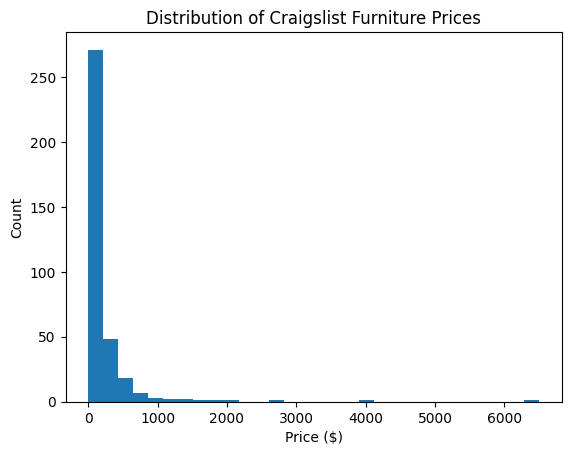

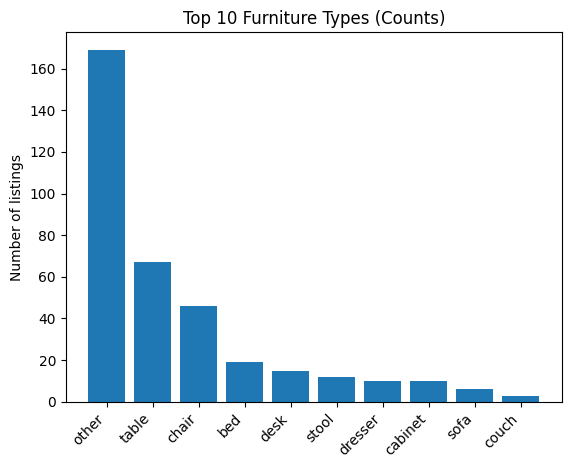

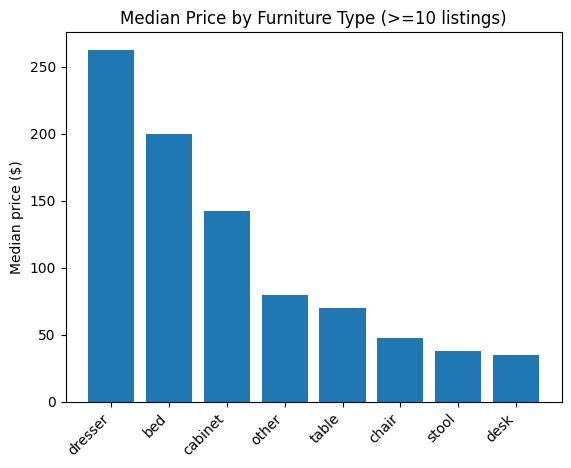

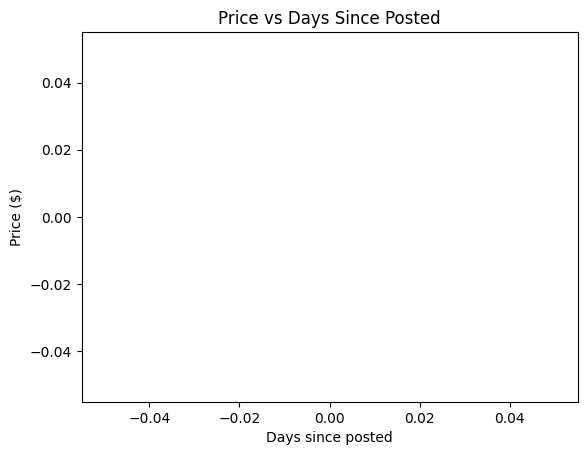

In [26]:
import matplotlib.pyplot as plt

# A) Histogram of prices
df_nonnull = df.dropna(subset=["price"])
plt.figure()
plt.hist(df_nonnull["price"], bins=30)
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.title("Distribution of Craigslist Furniture Prices")
plt.show()

# B) Top furniture types (bar chart)
top_types = df["furniture_type"].value_counts().head(10)
plt.figure()
plt.bar(top_types.index, top_types.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of listings")
plt.title("Top 10 Furniture Types (Counts)")
plt.show()

# C) Median price by furniture type (for types with at least 10 listings)
eligible = summary_by_type[summary_by_type["count"] >= 10].copy()
eligible = eligible.sort_values("median", ascending=False).head(12)

plt.figure()
plt.bar(eligible.index, eligible["median"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Median price ($)")
plt.title("Median Price by Furniture Type (>=10 listings)")
plt.show()

# D) Price vs days since posted (scatter)
df_scatter = df.dropna(subset=["price", "days_since_posted"])
plt.figure()
plt.scatter(df_scatter["days_since_posted"], df_scatter["price"], alpha=0.5)
plt.xlabel("Days since posted")
plt.ylabel("Price ($)")
plt.title("Price vs Days Since Posted")
plt.show()

In [28]:
import os
os.makedirs("./src", exist_ok=True)
df.to_csv("./src/craigslist_cville_furniture.csv", index=False)


In [29]:
price_by_type = (
    df.dropna(subset=["price"])
      .groupby("furniture_type")["price"]
      .median()
      .sort_values(ascending=False)
)

price_by_type


,price
furniture_type,
dresser,262.5
bed,200.0
sofa,175.0
couch,165.0
cabinet,142.5
other,80.0
table,70.0
chair,47.5
stool,37.5


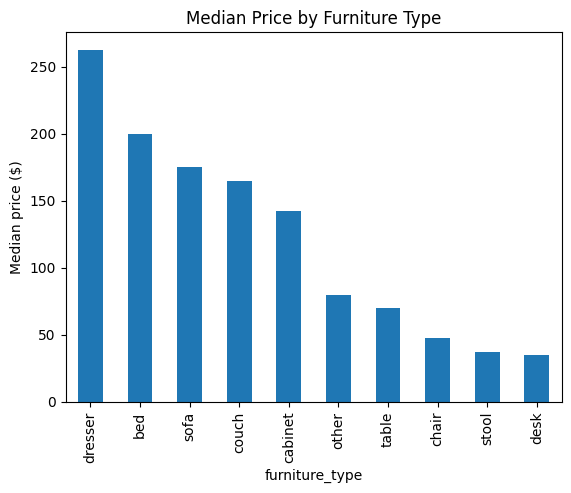

In [30]:
plt.figure()
price_by_type.head(10).plot(kind="bar")
plt.ylabel("Median price ($)")
plt.title("Median Price by Furniture Type")
plt.show()


We see that the larger, more sought after pieces of furniture are more expensive as they are when bought new.